In [3]:
import sys
import torchvision
import numpy as np
from envs.navigation.State import State
from envs.navigation.DiscreteStateSpace import DiscreteStateSpace
from envs.navigation.Dynamics import XYDynamics
from envs.navigation.StateFeature import FeatureStateIndicator, FeatureStateIndicatorOneHot, \
                                        FeatureClassIndicator, FeatureClassIndicatorOneHot, \
                                        FeatureClassImage, FeatureClassImageSampler
from envs.navigation.StateReward import RewardStateScalar
import rl.planning as Plan
import rl.policy as Policy

sys.path.append("./NavigationGridViews/")
from NavigationGridViews.navgridviews.Raster import Raster as NavGridView

from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

In [4]:
cifar = torchvision.datasets.CIFAR100(root="./", download=True)
X, y = cifar.data, np.asarray(cifar.targets)
classes = np.unique(y)
n_classes = len(classes)

print(X.shape, y.shape)

def sample_image(X, y, y_q):
    x_q = X[y == y_q]
    return x_q[np.random.randint(0, len(x_q))]

Files already downloaded and verified
(50000, 32, 32, 3) (50000,)


In [5]:
cifar.classes.index("house"), cifar.classes.index("skyscraper"), cifar.classes.index("road")

(37, 76, 68)

## Gridworld 5x5

In [6]:
np.random.seed(5)
# Specify state space
S = DiscreteStateSpace(5,5)
goal = (4,4)

# Attach classes
S.sample_and_attach_classes([37, 76, 68], [0.2, 0.3, 0.5])
S.override_classes_by_loc([goal], [68])
# Attach features
S.attach_features(FeatureClassImageSampler(S, lambda x: sample_image(X, y, x)))
PHI = S.features()
PHI_gridded = S.features(gridded=True)
PHI_gridded_inverted = np.flip(PHI_gridded, 2)
# Attach rewards
S.attach_rewards(RewardStateScalar(S, loc_to_reward_dict={goal: 1.}, 
                                   class_id_to_reward_dict={37: 0, 76: 0, 68: 0}, default=0))
R = S.rewards()
# Specify dynamics
T = XYDynamics(S, slip_prob=0.)

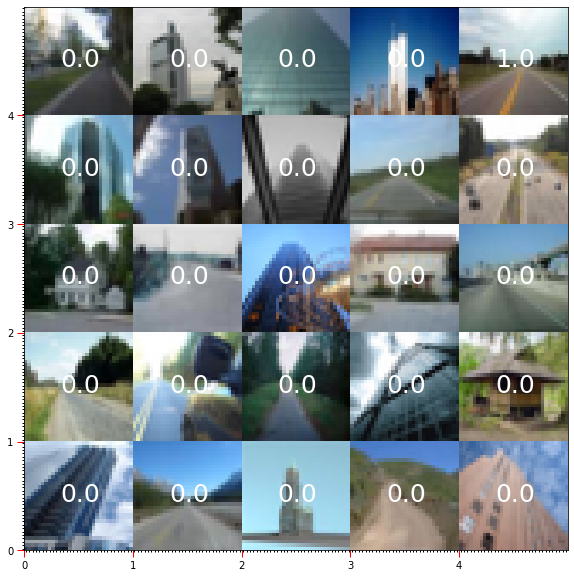

In [7]:
fig = plt.figure(figsize=(10,10))
p = NavGridView(PHI_gridded_inverted, ax=plt.gca()).render().ticks().show_cell_text(R, fontsize=25)
p.ax.invert_yaxis()

In [42]:
# Set goal
S.set_terminal_status_by_loc([goal])
vi = Plan.ValueIteration(S, R, T, verbose=True)
# vi.q_value_list(S[23], False)

In [45]:
log_Pi, V, Q, iterno = vi.run(100, Policy.Greedy, verbose=True, debug=False, eps=1e-10)

Running VI [  ] VI converged @ 7.


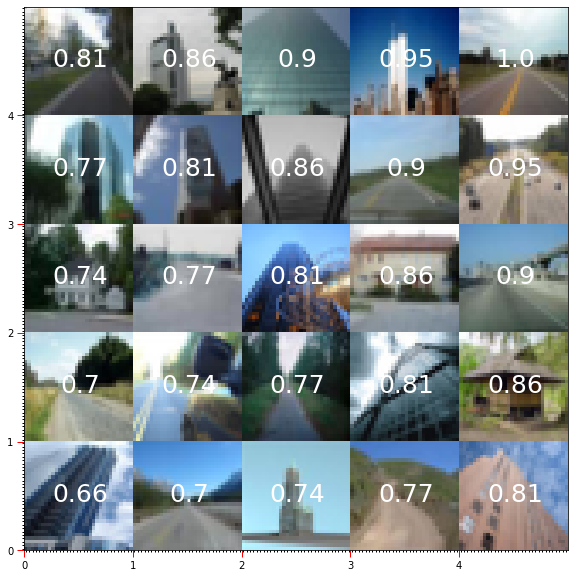

In [46]:
fig = plt.figure(figsize=(10,10))
p = NavGridView(PHI_gridded_inverted, ax=plt.gca()).render().ticks().show_cell_text(V.numpy().round(2), fontsize=25)
p.ax.invert_yaxis()